### Setup

If you want to write your own code and not follow this format, it is ok. Just make sure to use the same hyperparameters and models. If you see convergence sooner during the training, you may use fewer iterations.

In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

# Latent dimensions
z = 10
# Training iterations
iter_max = 50
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [2]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    # Create pre-processed training and test sets
    # X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    # y_train = train_loader.dataset.train_labels.to(device)
    # X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    # y_test = test_loader.dataset.test_labels.to(device)

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)
# train_loader

### Utility Functions
- Complete the code for the function ```sample_gaussian```

In [3]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    ################################################################################
    # TODO: complete the code here
    # Task: Sample z

    # Using reparameterization trick to sample from a gaussian

    # z = mu + sigma * eps
    # z = mu + sqrt(exp(sigma)) * eps
    # z = mu + exp(sigma/2) * eps
    # z = mu + sqrt(var) * eps

    eps = torch.randn_like(v)
    z = m + torch.sqrt(v) * eps

    # End
    ################################################################################

    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl



def duplicate(x, rep):
    """
    Duplicates x along dim=0

    Args:
        x: tensor: (batch, ...): Arbitrary tensor
        rep: int: (): Number of replicates. Setting rep=1 returns orignal x

    Returns:
        _: tensor: (batch * rep, ...): Arbitrary replicated tensor
    """
    return x.expand(rep, *x.shape).reshape(-1, *x.shape[1:])

def log_normal(x, m, v):
    """
    Computes the elem-wise log probability of a Gaussian and then sum over the
    last dim. Basically we're assuming all dims are batch dims except for the
    last dim.

    Args:
        x: tensor: (batch_1, batch_2, ..., batch_k, dim): Observation
        m: tensor: (batch_1, batch_2, ..., batch_k, dim): Mean
        v: tensor: (batch_1, batch_2, ..., batch_k, dim): Variance

    Return:
        log_prob: tensor: (batch_1, batch_2, ..., batch_k): log probability of
            each sample. Note that the summation dimension is not kept
    """
    log_std = torch.log(torch.sqrt(v))
    log_probs = -((x - m) ** 2) / (2 * v) - log_std - np.log(np.sqrt(2 * np.pi))
    log_prob = log_probs.sum(-1)

    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob

def log_mean_exp(x, dim):
    """
    Compute the log(mean(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which mean is computed

    Return:
        _: tensor: (...): log(mean(exp(x), dim))
    """
    return log_sum_exp(x, dim) - np.log(x.size(dim))


def log_sum_exp(x, dim=0):
    """
    Compute the log(sum(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which sum is computed

    Return:
        _: tensor: (...): log(sum(exp(x), dim))
    """
    max_x = torch.max(x, dim)[0]
    new_x = x - max_x.unsqueeze(dim).expand_as(x)
    return max_x + (new_x.exp().sum(dim)).log()


### Base Models

In [4]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

- Complete the functions ```negative_elbo_bound``` and ```negative_iwae_bound```. Make sure to use functions provided in the ***Utility*** and ***Base Model*** sections for your benefit when completing the code.

In [5]:
class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim

        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: complete the code here
        # Task: Compute negative Evidence Lower Bound and its KL and Reconstruction term
        # Note that nelbo = kl + rec
        # Outputs should all be scalar

        # Encoder
        qm, qv = self.enc.encode(x)
        z = sample_gaussian(qm,qv)

        # kl
        kl = torch.mean(kl_normal(qm, qv, self.z_prior_m, self.z_prior_v))

        # rec
        x_hat = self.dec.decode(z)
        rec =  -1.0 * torch.mean(log_bernoulli_with_logits(x, x_hat))


        nelbo = kl + rec
        # End
        ################################################################################

        return nelbo, kl, rec

    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: Modify/complete the code here
        # Compute niwae (negative IWAE) with iw importance samples, and the KL
        # and Rec decomposition of the Evidence Lower Bound
        #
        # Outputs should all be scalar
        ################################################################################

        # Encoder
        qm, qv = self.enc.encode(x)
        z = sample_gaussian(qm,qv)
        multi_z = duplicate(z, iw)

        # kl
        kl = torch.mean(kl_normal(qm, qv, self.z_prior_m, self.z_prior_v))

        # rec
        multi_x_hat = self.dec.decode(multi_z)
        multi_x = duplicate(x, iw)
        recs =  log_bernoulli_with_logits(multi_x, multi_x_hat)

        log_weights = recs - kl
        neg_rec =  torch.mean(recs)

        niwae = -1.0 * (log_mean_exp(log_weights, dim=-1))

        ################################################################################
        # End of code modification
        ################################################################################
        return niwae, kl, neg_rec




    def loss(self, x ,loss_function = 'NELBO', m=None):

        if loss_function == 'NELBO':
          nelbo, kl, rec = self.negative_elbo_bound(x)
          loss = nelbo

          summaries = dict((
              ('train/loss', nelbo),
              ('gen/kl_z', kl),
              ('gen/rec', rec),
          ))
        else:
          if not m:
            return

          niwae, kl, rec = self.negative_iwae_bound(x , m)
          loss = niwae
          summaries = dict((
              ('train/loss', niwae),
              ('gen/kl_z', kl),
              ('gen/rec', rec),
          ))


        return loss, summaries


    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


### Run model

- You will probably need to add some lines to this code. (Add test set, save statistics and plot, ...)

Note that Negative ELBO on the test set should be around 100.

In [7]:
train_nelbo = []
train_rec = []
train_kl = []

test_nelbo = []
test_rec = []
test_kl = []

vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

for i in tqdm(range(iter_max)):
  total_nelbo = 0
  total_kl = 0
  total_rec = 0

  for batch_idx, (xu, yu) in enumerate(train_loader):

      optimizer.zero_grad()

      xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
      yu = yu.new(np.eye(10)[yu]).to(device).float()
      loss, summaries = vae.loss(xu)

      total_nelbo += loss
      total_rec += summaries['gen/rec']
      total_kl += summaries['gen/kl_z']

      loss.backward()
      optimizer.step()

  ################################################################################
  # TODO: complete the code here
  # report the loss terms across time for train and validation datasets
  #
  # You can choose to only perform validation once in every 10 (Or any other number
  # depending on the speed of the algorithm on your machine) iterations and display
  # the training and validation statistics on those iterataions.

  train_nelbo.append(total_nelbo.detach().item()/len(train_loader))
  train_rec.append(total_rec.detach().item()/len(train_loader))
  train_kl.append(total_kl.detach().item()/len(train_loader))

  if i % 25 == 0:
    print(" train/Epoch:{}, Loss:{}, reconstruction:{}, kl:{} ".format(i+1, round(summaries['train/loss'].item(),3),\
                                                              round(summaries['gen/rec'].item(),3), round(summaries['gen/kl_z'].item(),3)))

  print(train_rec)


  with torch.no_grad():
    test_total_nelbo = 0
    test_total_kl = 0
    test_total_rec = 0

    for batch_idx, (xu, yu) in enumerate(test_loader):
        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        test_loss, test_summaries = vae.loss(xu)


        test_total_nelbo += test_loss
        test_total_kl += test_summaries['gen/rec']
        test_total_rec += test_summaries['gen/kl_z']


  test_nelbo.append(test_total_nelbo.detach().item()/len(test_loader))
  test_kl.append(test_total_kl.detach().item()/len(test_loader))
  test_rec.append(test_total_rec.detach().item()/len(test_loader))

  if i % 25 == 0:
    print(" test/Epoch:{}, Loss:{}, reconstruction:{}, kl:{} ".format(i+1, round(test_summaries['train/loss'].item(),3),\
                                                              round(test_summaries['gen/rec'].item(),3), round(test_summaries['gen/kl_z'].item(),3)))
  print(test_rec)

  # End
  ################################################################################

  0%|          | 0/50 [00:00<?, ?it/s]

 train/Epoch:1, Loss:126.17, reconstruction:111.289, kl:14.881 


  2%|▏         | 1/50 [00:19<15:49, 19.37s/it]

 test/Epoch:1, Loss:124.731, reconstruction:109.939, kl:14.792 


 20%|██        | 10/50 [01:48<06:38,  9.97s/it]

 train/Epoch:11, Loss:102.752, reconstruction:83.616, kl:19.136 


 22%|██▏       | 11/50 [02:00<06:47, 10.44s/it]

 test/Epoch:11, Loss:103.271, reconstruction:84.251, kl:19.021 


 40%|████      | 20/50 [03:28<04:55,  9.85s/it]

 train/Epoch:21, Loss:107.906, reconstruction:88.189, kl:19.717 


 42%|████▏     | 21/50 [03:38<04:44,  9.81s/it]

 test/Epoch:21, Loss:100.706, reconstruction:81.657, kl:19.05 


 60%|██████    | 30/50 [05:08<03:19,  9.98s/it]

 train/Epoch:31, Loss:96.244, reconstruction:76.933, kl:19.311 


 62%|██████▏   | 31/50 [05:18<03:10, 10.01s/it]

 test/Epoch:31, Loss:99.989, reconstruction:80.571, kl:19.418 


 80%|████████  | 40/50 [06:46<01:37,  9.73s/it]

 train/Epoch:41, Loss:96.122, reconstruction:76.818, kl:19.303 


 82%|████████▏ | 41/50 [06:56<01:28,  9.82s/it]

 test/Epoch:41, Loss:98.916, reconstruction:79.874, kl:19.043 


100%|██████████| 50/50 [08:25<00:00, 10.10s/it]


In [8]:
import matplotlib.pyplot as plt

def plot_data(train, test, title, x_label, y_label):
    plt.plot(train, 'g--', label='Train')  # Green dashed line for train data
    plt.plot(test, label='Test')   # Blue triangle markers for test data
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

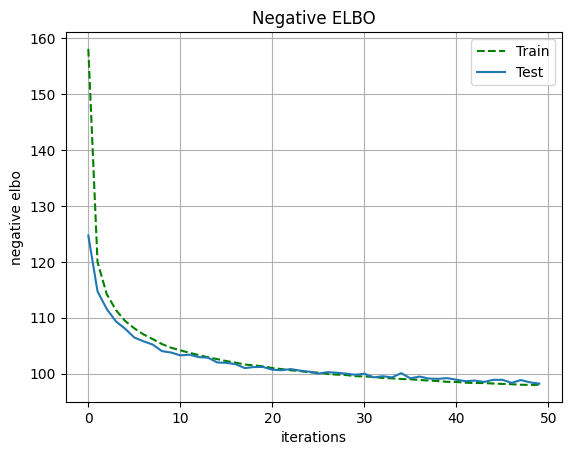

In [9]:
plot_data(train_nelbo, test_nelbo, "Negative ELBO", "iterations", "negative elbo")

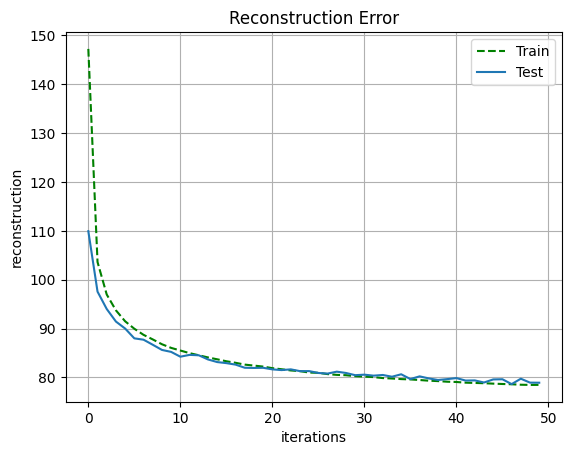

In [10]:
plot_data(train_rec, test_rec, "Reconstruction Error", "iterations", "reconstruction")

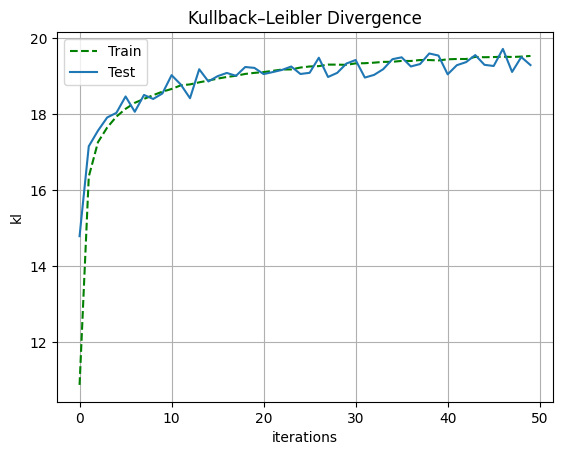

In [11]:
plot_data(train_kl, test_kl, "Kullback–Leibler Divergence", "iterations", "kl")

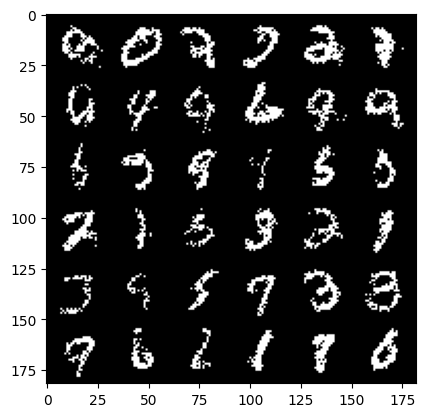

In [18]:
from torchvision.utils import make_grid
from matplotlib.pyplot import imshow
n = 36

samples = vae.sample_x(n).reshape(n,1,28,28)
grid = make_grid(samples.cpu(), nrow=int(np.sqrt(n)))
imshow(grid.permute(1,2,0))

IWAE


In [15]:
def evaluation(model, epoch, iw = None):

    with torch.no_grad():

      test_total_nelbo = 0
      test_total_kl = 0
      test_total_rec = 0

      model.eval()

      for batch_idx, (test_xu, test_yu) in enumerate(test_loader):
          test_xu = torch.bernoulli(test_xu.to(device).reshape(test_xu.size(0), -1))
          test_yu = test_yu.new(np.eye(10)[test_yu]).to(device).float()


          if not iw:
            return
          test_loss, test_summaries = model.loss(test_xu ,'iwae', iw)


          test_total_nelbo += test_loss
          test_total_kl += test_summaries['gen/rec']
          test_total_rec += test_summaries['gen/kl_z']

      # if epoch+1 % 10 == 0:
      #   print(" test/Epoch:{}, Loss:{}, reconstruction:{}, kl:{} ".format(i+1, round(test_summaries['train/loss'].item(),3),\
      #                                                         round(test_summaries['gen/rec'].item(),3), round(test_summaries['gen/kl_z'].item(),3)))

      return test_total_nelbo ,test_total_kl ,test_total_rec, len(test_loader)


In [16]:
log_loss = {}
log_kl = {}
log_rec = {}


for iw in [5 , 50 , 150]:
  test_loss_iwae = []
  test_kl_iwae = []
  test_rec_iwae = []

  for i in range(iter_max):
    loss, kl, rec, l = evaluation(vae , i , iw)
    test_loss_iwae.append(loss.detach().item()/ l)
    test_kl_iwae.append(kl.detach().item()/ l)
    test_rec_iwae.append(rec.detach().item()/ l)


  log_loss[iw] = np.mean(test_loss_iwae)
  log_kl[iw] = np.mean(test_loss_iwae)
  log_rec[iw] = np.mean(test_rec_iwae)


In [17]:
for iw in [5 , 50 , 150]:
  print("----------------------------------------------")
  print("iw: {}".format(iw))
  print("Loss: {}".format( log_loss[iw]))
  print("Reconstruction: {}".format(log_rec[iw]))
  print("KL: {}".format(log_kl[iw]))


----------------------------------------------
iw: 5
Loss: 47.151198242187505
Reconstruction: 19.285231494140625
KL: 47.151198242187505
----------------------------------------------
iw: 50
Loss: 47.08394707031249
Reconstruction: 19.285521630859375
KL: 47.08394707031249
----------------------------------------------
iw: 150
Loss: 47.11121630859375
Reconstruction: 19.285015039062497
KL: 47.11121630859375
